In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
from sklearn.datasets import load_iris
data, label = load_iris(return_X_y=True)
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [3]:
from sklearn.model_selection import train_test_split
X = torch.from_numpy(data).type(torch.float)
y = torch.from_numpy(label).type(torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [4]:
d = load_iris()
d.feature_names, d.target_names

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

C:\Users\Ravi\AppData\Local\Temp\ipykernel_17724\2361965395.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  ax.scatter(X_2d[idx, 0], X_2d[idx, 1], c=color, label=f'Class {d.target_names[i]}', edgecolor='black')


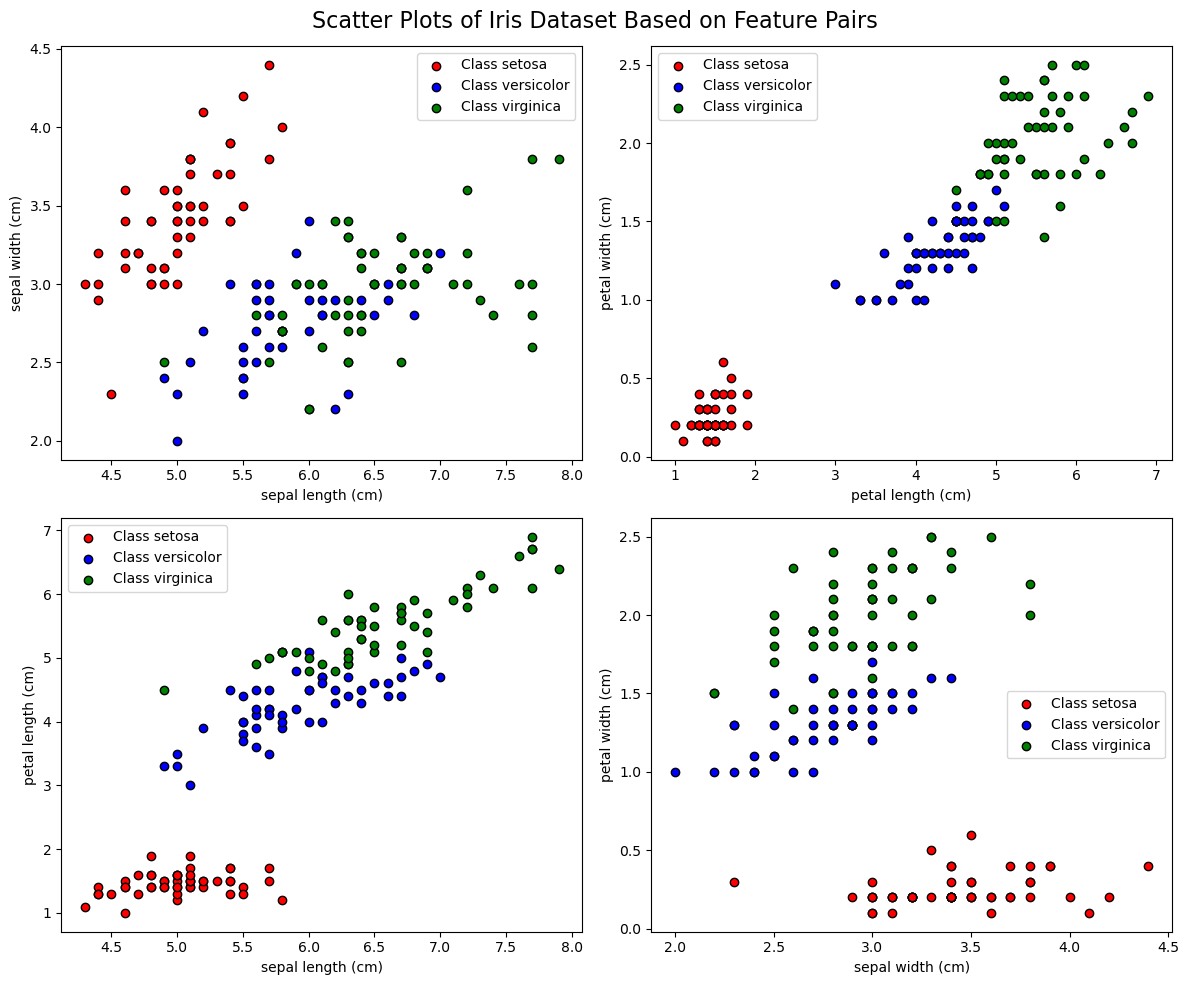

In [5]:
feature_pairs = [
    (0, 1),  # Sepal Length, Sepal Width
    (2, 3),  # Petal Length, Petal Width
    (0, 2),  # Sepal Length, Petal Length
    (1, 3)   # Sepal Width Petal Width
]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Scatter Plots of Iris Dataset Based on Feature Pairs', fontsize=16)

# Plot each feature pair in a subplot
for ax, (feature1_index, feature2_index) in zip(axes.flat, feature_pairs):
    X_2d = X[:, [feature1_index, feature2_index]]  # Select the two features
    for i, color in zip(range(3), ['red', 'blue', 'green']):
        idx = np.where(y == i)
        ax.scatter(X_2d[idx, 0], X_2d[idx, 1], c=color, label=f'Class {d.target_names[i]}', edgecolor='black')
    
    ax.set_xlabel(d.feature_names[feature1_index])
    ax.set_ylabel(d.feature_names[feature2_index])
    ax.legend()

plt.tight_layout()
plt.show()

In [6]:
class IrisModel(nn.Module):
    def __init__(self, hidden_layer_neurons=8):
        super().__init__() 
        self.layers = nn.Sequential(
            nn.Linear(in_features=4, out_features=hidden_layer_neurons),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_neurons, out_features=hidden_layer_neurons),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_neurons, out_features=3)
        )

    def forward(self, x):
        return self.layers(x)

In [7]:
device = 'cpu'

In [8]:
model_0 = IrisModel()
model_0.to(device)
next(model_0.parameters()).device

device(type='cpu')

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(), lr = 0.01
)

In [10]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [11]:
epochs = 2000
torch.manual_seed(42)
trainLossList = []
testLossList = []
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train)  # Raw logits (no sigmoid)
    y_pred = torch.argmax(y_logits, dim=1)  # Convert logits to predicted class indices

    # Training loss
    loss = loss_fn(y_logits, y_train)  # CrossEntropyLoss expects raw logits and class indices
    trainLossList.append(loss.cpu().detach().numpy())

    # Zero grad optimizer
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Update weights
    optimizer.step()

    # Calculate accuracy
    acc = accuracy(y_true=y_train, y_pred=y_pred)

    # Evaluation
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test)  # Raw logits (no sigmoid)
        test_preds = torch.argmax(test_logits, dim=1)  # Convert logits to predicted class indices
        test_loss = loss_fn(test_logits, y_test)  # CrossEntropyLoss expects raw logits and class indices
        testLossList.append(test_loss.cpu().detach().numpy())
        test_acc = accuracy(y_test, test_preds)

    # Print progress
    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}"
            f"\n     | Train Accuracy: {acc:.4f} | Test Accuracy: {test_acc:.4f}"
        )

Epoch: 0 | Train Loss: 1.0891 | Test Loss: 1.1052
     | Train Accuracy: 35.0000 | Test Accuracy: 26.6667
Epoch: 100 | Train Loss: 0.8581 | Test Loss: 0.8253
     | Train Accuracy: 65.8333 | Test Accuracy: 73.3333
Epoch: 200 | Train Loss: 0.5811 | Test Loss: 0.4956
     | Train Accuracy: 69.1667 | Test Accuracy: 83.3333
Epoch: 300 | Train Loss: 0.4446 | Test Loss: 0.3504
     | Train Accuracy: 90.8333 | Test Accuracy: 96.6667
Epoch: 400 | Train Loss: 0.3557 | Test Loss: 0.2594
     | Train Accuracy: 95.0000 | Test Accuracy: 100.0000
Epoch: 500 | Train Loss: 0.2848 | Test Loss: 0.1899
     | Train Accuracy: 95.8333 | Test Accuracy: 100.0000
Epoch: 600 | Train Loss: 0.2285 | Test Loss: 0.1394
     | Train Accuracy: 97.5000 | Test Accuracy: 100.0000
Epoch: 700 | Train Loss: 0.1873 | Test Loss: 0.1067
     | Train Accuracy: 97.5000 | Test Accuracy: 100.0000
Epoch: 800 | Train Loss: 0.1585 | Test Loss: 0.0862
     | Train Accuracy: 97.5000 | Test Accuracy: 100.0000
Epoch: 900 | Train Loss: 

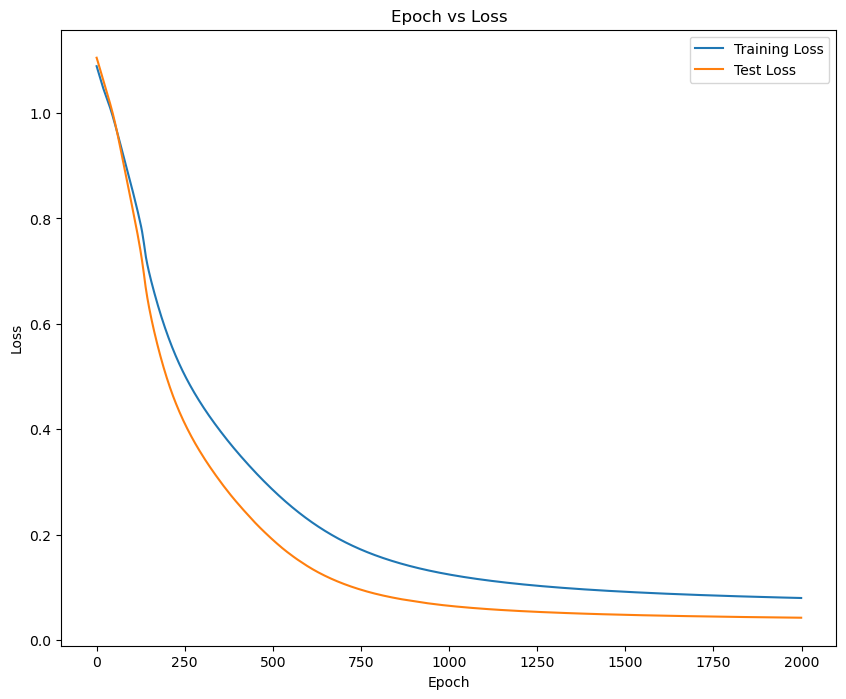

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(range(epochs), trainLossList, label="Training Loss")
plt.plot(range(epochs), testLossList, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend();

In [13]:
with torch.inference_mode():
    y_pred = torch.argmax(model_0(X_test), dim=1)

In [14]:
y_pred

tensor([0, 0, 2, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 2,
        2, 2, 0, 1, 0, 0])

In [15]:

def plot_iris_comparison(X, y_true, y_pred, feature_pairs):
    """
    Plot scatter plots comparing true and predicted classifications for Iris dataset
    
    Parameters:
    X: feature array
    y_true: true labels
    y_pred: predicted labels
    feature_pairs: list of tuples containing feature index pairs to plot
    """
    
    # Load iris dataset for feature names
    d = load_iris()
    
    # Create a figure with side-by-side comparisons
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Comparison of True vs Predicted Classifications - Iris Dataset', fontsize=16)
    
    # Plot true labels on the left, predicted on the right
    for idx, (feature1_index, feature2_index) in enumerate(feature_pairs):
        # Select the two features
        X_2d = X[:, [feature1_index, feature2_index]]
        
        # Plot true labels
        ax_true = axes[idx // 2, idx % 2 * 2]
        ax_true.set_title(f'True Labels\n{d.feature_names[feature1_index]} vs {d.feature_names[feature2_index]}')
        
        # Plot predicted labels
        ax_pred = axes[idx // 2, idx % 2 * 2 + 1]
        ax_pred.set_title(f'Predicted Labels\n{d.feature_names[feature1_index]} vs {d.feature_names[feature2_index]}')
        
        # Plot each class
        for i, color in zip(range(3), ['red', 'blue', 'green']):
            # True labels
            idx_true = np.where(y_true == i)
            ax_true.scatter(X_2d[idx_true, 0], X_2d[idx_true, 1], 
                          c=color, label=f'Class {d.target_names[i]}', 
                          edgecolor='black')
            
            # Predicted labels
            idx_pred = np.where(y_pred == i)
            ax_pred.scatter(X_2d[idx_pred, 0], X_2d[idx_pred, 1], 
                          c=color, label=f'Class {d.target_names[i]}', 
                          edgecolor='black')
        
        # Set labels and legend
        for ax in [ax_true, ax_pred]:
            ax.set_xlabel(d.feature_names[feature1_index])
            ax.set_ylabel(d.feature_names[feature2_index])
            ax.legend()
    
    plt.tight_layout()
    plt.show()

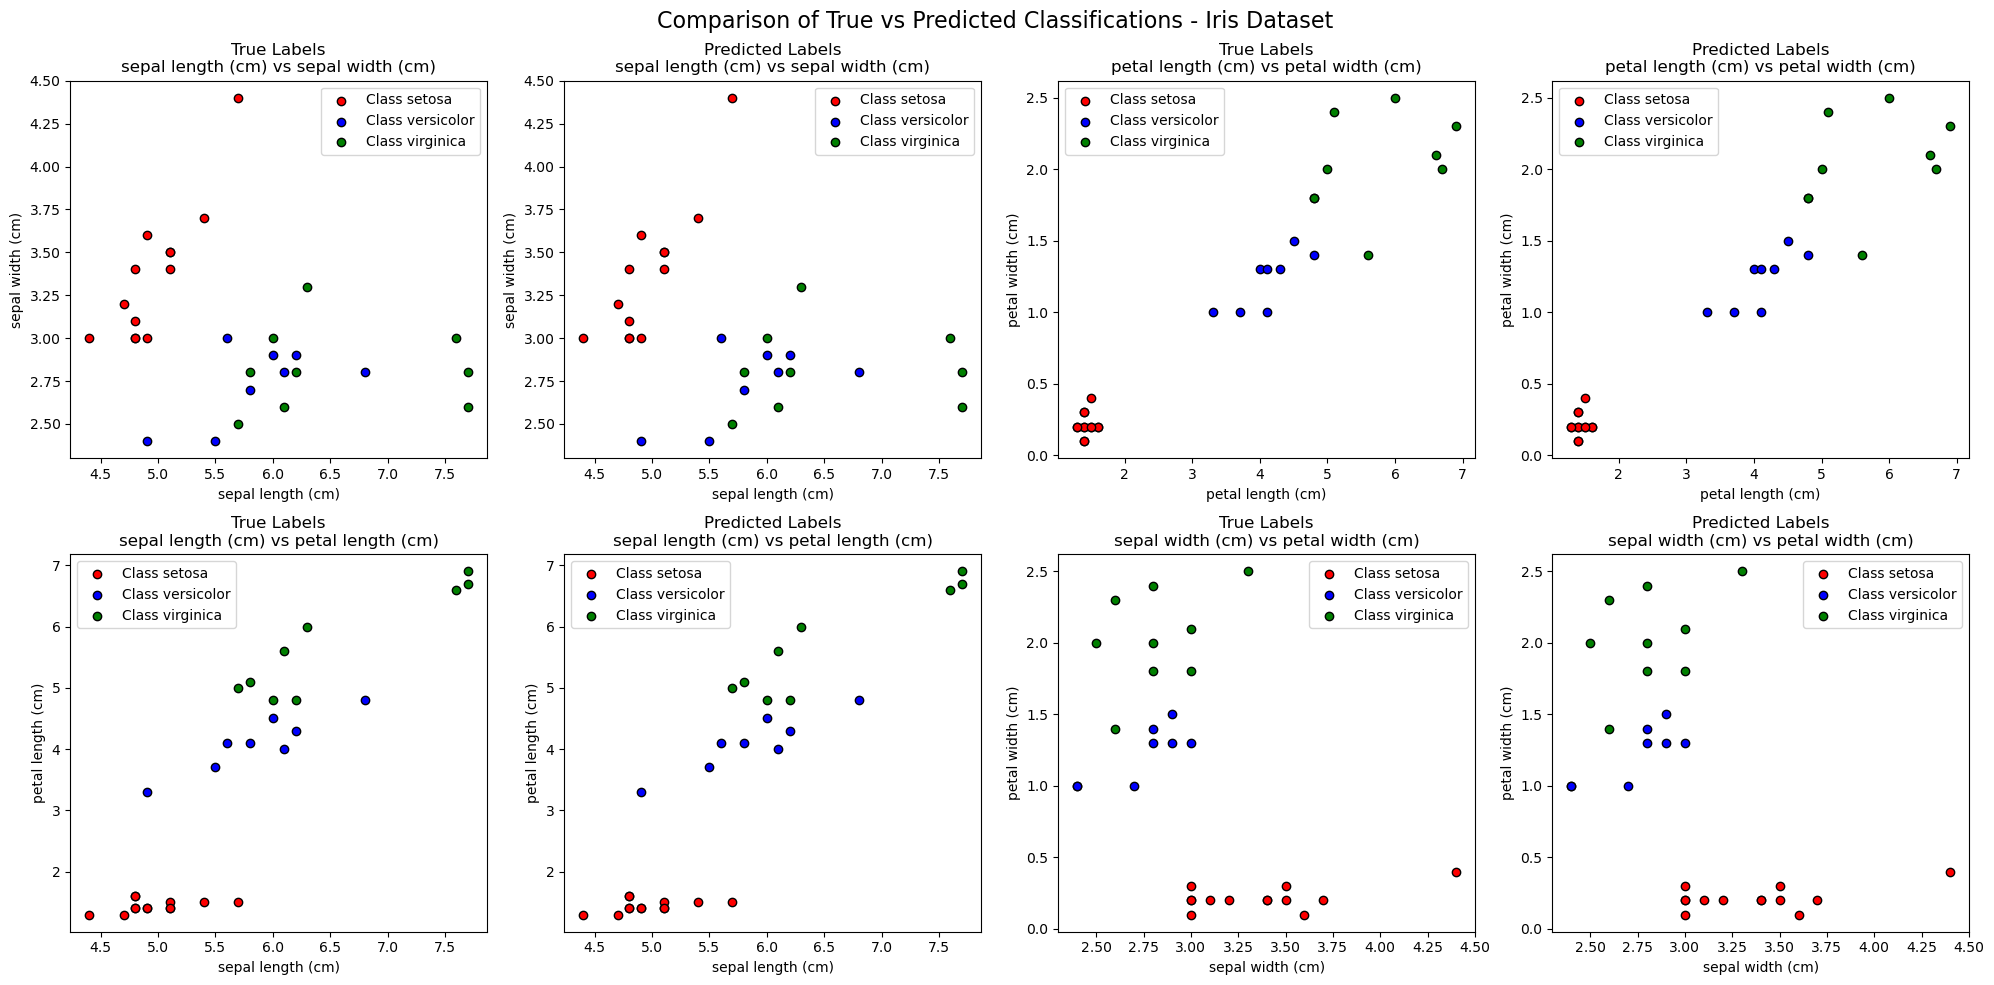

In [16]:
plot_iris_comparison(X_test, y_test, y_pred, feature_pairs)

In [17]:
torch.save(model_0.state_dict(), "iris_model")